In [67]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [68]:
# Create Tensors to hold input and outputs.
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,4]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,2]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,3]),np.zeros(90))

#第一组参数
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,8]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,6]),np.zeros(90))

#第二组参数
beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,4,-6,-8]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,-2,-3,4]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,4.5,6]),np.zeros(90))

beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0
prior=[1,2,3,4,5,11,12,13,14,15]

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


In [69]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)


In [70]:
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()

tensor(0.2250, dtype=torch.float64)

tensor(0.2174, dtype=torch.float64)

tensor(0.2192, dtype=torch.float64)

In [71]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [72]:
################## first step##################

# choose lambda1,lambda2 by ray tune

prior=[1,2,3,4,5,11,12,13,14,15]
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)



    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lr,ga= config["lambda1"], config["lambda2"],config["lr"],config["ga"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params,
                                           model_2_all_linear2_params,model_2_all_linear3_params,
                                           model_3_all_linear2_params,model_3_all_linear3_params),0)
            
            non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear23_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3= model_3(train_x3[idx_test])
        
        test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
        test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
        test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))
        
        test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
        sum_test_BCE_loss+=test_BCE_loss.item()

    #print("loss: ",)
    tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lr":tune.choice([0.6,0.7,0.8]),
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "ga":tune.choice([0.3,0.4,0.5])
    }
    result = tune.run(
        train_model,  
        config=config,
        num_samples=120)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,ga,lambda1,lambda2,lr,iter,total time (s),my_test_BCE_loss
train_model_c6dce_00000,TERMINATED,10.224.0.12:27875,0.3,0.05,0.001,0.8,1,13.5127,1.7327
train_model_c6dce_00001,TERMINATED,10.224.0.12:28304,0.4,0.03,0.002,0.8,1,14.4565,1.48528
train_model_c6dce_00002,TERMINATED,10.224.0.12:28306,0.3,0.05,0.002,0.8,1,13.8509,1.57796
train_model_c6dce_00003,TERMINATED,10.224.0.12:28308,0.4,0.05,0.003,0.8,1,14.0426,1.59753
train_model_c6dce_00004,TERMINATED,10.224.0.12:28310,0.4,0.03,0.001,0.8,1,13.1135,1.575
train_model_c6dce_00005,TERMINATED,10.224.0.12:28312,0.3,0.03,0.003,0.6,1,13.3911,1.73485
train_model_c6dce_00006,TERMINATED,10.224.0.12:28314,0.5,0.03,0.001,0.7,1,13.405,1.5301
train_model_c6dce_00007,TERMINATED,10.224.0.12:28316,0.3,0.05,0.002,0.8,1,13.7658,1.57796
train_model_c6dce_00008,TERMINATED,10.224.0.12:28318,0.3,0.04,0.001,0.7,1,13.9795,1.69395
train_model_c6dce_00009,TERMINATED,10.224.0.12:28320,0.3,0.05,0.001,0.6,1,13.7389,1.78434


Result for train_model_c6dce_00000:
  date: 2022-11-13_19-39-20
  done: false
  experiment_id: 4ee2a87ecea744fa8a8b557386e2ecde
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7327036142349244
  node_ip: 10.224.0.12
  pid: 27875
  time_since_restore: 13.512732744216919
  time_this_iter_s: 13.512732744216919
  time_total_s: 13.512732744216919
  timestamp: 1668339560
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00000
  warmup_time: 0.003355264663696289
  
Result for train_model_c6dce_00000:
  date: 2022-11-13_19-39-20
  done: true
  experiment_id: 4ee2a87ecea744fa8a8b557386e2ecde
  experiment_tag: 0_ga=0.3000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7327036142349244
  node_ip: 10.224.0.12
  pid: 27875
  time_since_restore: 13.512732744216919
  time_this_iter_s: 13.512732744216919
  time_total_s: 13.512732744216919
  timestamp: 1668339560
  times

Result for train_model_c6dce_00017:
  date: 2022-11-13_19-39-24
  done: false
  experiment_id: 4ff04d42a9634066bbca5c41b58e9e94
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.78433518409729
  node_ip: 10.224.0.12
  pid: 28336
  time_since_restore: 13.556079387664795
  time_this_iter_s: 13.556079387664795
  time_total_s: 13.556079387664795
  timestamp: 1668339564
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00017
  warmup_time: 0.0037467479705810547
  
Result for train_model_c6dce_00018:
  date: 2022-11-13_19-39-24
  done: true
  experiment_id: d917f9358dde40e0a1d68e16a54316e1
  experiment_tag: 18_ga=0.5000,lambda1=0.0300,lambda2=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.530096697807312
  node_ip: 10.224.0.12
  pid: 28338
  time_since_restore: 13.572145223617554
  time_this_iter_s: 13.572145223617554
  time_total_s: 13.572145223617554
  timestamp: 1668339564
  timest

Result for train_model_c6dce_00007:
  date: 2022-11-13_19-39-25
  done: false
  experiment_id: dcbcbe3bf2b14aeab6735f070500abac
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5779582023620606
  node_ip: 10.224.0.12
  pid: 28316
  time_since_restore: 13.765812873840332
  time_this_iter_s: 13.765812873840332
  time_total_s: 13.765812873840332
  timestamp: 1668339565
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00007
  warmup_time: 0.0034911632537841797
  
Result for train_model_c6dce_00007:
  date: 2022-11-13_19-39-25
  done: true
  experiment_id: dcbcbe3bf2b14aeab6735f070500abac
  experiment_tag: 7_ga=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5779582023620606
  node_ip: 10.224.0.12
  pid: 28316
  time_since_restore: 13.765812873840332
  time_this_iter_s: 13.765812873840332
  time_total_s: 13.765812873840332
  timestamp: 1668339565
  time

Result for train_model_c6dce_00011:
  date: 2022-11-13_19-39-25
  done: false
  experiment_id: 1c1689c949794b54a48f1cef8f3e071e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8047592163085937
  node_ip: 10.224.0.12
  pid: 28324
  time_since_restore: 14.477992296218872
  time_this_iter_s: 14.477992296218872
  time_total_s: 14.477992296218872
  timestamp: 1668339565
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00011
  warmup_time: 0.006283283233642578
  
Result for train_model_c6dce_00011:
  date: 2022-11-13_19-39-25
  done: true
  experiment_id: 1c1689c949794b54a48f1cef8f3e071e
  experiment_tag: 11_ga=0.5000,lambda1=0.0500,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8047592163085937
  node_ip: 10.224.0.12
  pid: 28324
  time_since_restore: 14.477992296218872
  time_this_iter_s: 14.477992296218872
  time_total_s: 14.477992296218872
  timestamp: 1668339565
  time

Result for train_model_c6dce_00033:
  date: 2022-11-13_19-39-37
  done: true
  experiment_id: 3c1e4accd6df49ce9a3c42b3c504dd2c
  experiment_tag: 33_ga=0.3000,lambda1=0.0400,lambda2=0.0030,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5916594982147216
  node_ip: 10.224.0.12
  pid: 28314
  time_since_restore: 12.642632007598877
  time_this_iter_s: 12.642632007598877
  time_total_s: 12.642632007598877
  timestamp: 1668339577
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00033
  warmup_time: 0.005193948745727539
  
Result for train_model_c6dce_00036:
  date: 2022-11-13_19-39-37
  done: false
  experiment_id: 065ceb4b3a32459c8c3b74a6373ade02
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5395802497863769
  node_ip: 10.224.0.12
  pid: 28342
  time_since_restore: 12.429664611816406
  time_this_iter_s: 12.429664611816406
  time_total_s: 12.429664611816406
  timestamp: 1668339577
  time

Result for train_model_c6dce_00037:
  date: 2022-11-13_19-39-37
  done: true
  experiment_id: 6ea806413cc44624ba1987436d470661
  experiment_tag: 37_ga=0.3000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7863055229187013
  node_ip: 10.224.0.12
  pid: 28353
  time_since_restore: 13.060438632965088
  time_this_iter_s: 13.060438632965088
  time_total_s: 13.060438632965088
  timestamp: 1668339577
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00037
  warmup_time: 0.01112985610961914
  
Result for train_model_c6dce_00042:
  date: 2022-11-13_19-39-37
  done: false
  experiment_id: 6216540bb70e49efb34ced6f76f9661c
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6299660444259643
  node_ip: 10.224.0.12
  pid: 28344
  time_since_restore: 12.964756488800049
  time_this_iter_s: 12.964756488800049
  time_total_s: 12.964756488800049
  timestamp: 1668339577
  times

Result for train_model_c6dce_00053:
  date: 2022-11-13_19-39-38
  done: false
  experiment_id: d90b14a75a984ce599c228f1908f3591
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.576584243774414
  node_ip: 10.224.0.12
  pid: 28318
  time_since_restore: 13.011000156402588
  time_this_iter_s: 13.011000156402588
  time_total_s: 13.011000156402588
  timestamp: 1668339578
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00053
  warmup_time: 0.005162954330444336
  
Result for train_model_c6dce_00051:
  date: 2022-11-13_19-39-38
  done: false
  experiment_id: 41ea81848e0f45b99603daeaf35edec6
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7849650144577027
  node_ip: 10.224.0.12
  pid: 28308
  time_since_restore: 13.111999273300171
  time_this_iter_s: 13.111999273300171
  time_total_s: 13.111999273300171
  timestamp: 1668339578
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00051


Result for train_model_c6dce_00047:
  date: 2022-11-13_19-39-39
  done: true
  experiment_id: 6fdcea4e67c347a5a9daef8490b50a4b
  experiment_tag: 47_ga=0.3000,lambda1=0.0300,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6544380903244018
  node_ip: 10.224.0.12
  pid: 28320
  time_since_restore: 14.238542079925537
  time_this_iter_s: 14.238542079925537
  time_total_s: 14.238542079925537
  timestamp: 1668339579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00047
  warmup_time: 0.00530695915222168
  
Result for train_model_c6dce_00061:
  date: 2022-11-13_19-39-39
  done: false
  experiment_id: 5c8469f5998742299ca344958ab16887
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.5975306749343872
  node_ip: 10.224.0.12
  pid: 28364
  time_since_restore: 13.656439542770386
  time_this_iter_s: 13.656439542770386
  time_total_s: 13.656439542770386
  timestamp: 1668339579
  times

Result for train_model_c6dce_00075:
  date: 2022-11-13_19-39-50
  done: true
  experiment_id: 6216540bb70e49efb34ced6f76f9661c
  experiment_tag: 75_ga=0.4000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.8005571603775024
  node_ip: 10.224.0.12
  pid: 28344
  time_since_restore: 12.615095376968384
  time_this_iter_s: 12.615095376968384
  time_total_s: 12.615095376968384
  timestamp: 1668339590
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00075
  warmup_time: 0.005057573318481445
  
Result for train_model_c6dce_00074:
  date: 2022-11-13_19-39-50
  done: false
  experiment_id: 6ea806413cc44624ba1987436d470661
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4816649198532104
  node_ip: 10.224.0.12
  pid: 28353
  time_since_restore: 12.809247493743896
  time_this_iter_s: 12.809247493743896
  time_total_s: 12.809247493743896
  timestamp: 1668339590
  time

Result for train_model_c6dce_00080:
  date: 2022-11-13_19-39-51
  done: true
  experiment_id: cf97d699afc149b489de685f5dd1bd80
  experiment_tag: 80_ga=0.5000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.4177953124046325
  node_ip: 10.224.0.12
  pid: 28306
  time_since_restore: 12.952636957168579
  time_this_iter_s: 12.952636957168579
  time_total_s: 12.952636957168579
  timestamp: 1668339591
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00080
  warmup_time: 0.006639719009399414
  
Result for train_model_c6dce_00085:
  date: 2022-11-13_19-39-51
  done: false
  experiment_id: 55154400afb34178870020e1a6392b5d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6905327081680297
  node_ip: 10.224.0.12
  pid: 28328
  time_since_restore: 12.75120496749878
  time_this_iter_s: 12.75120496749878
  time_total_s: 12.75120496749878
  timestamp: 1668339591
  timeste

Result for train_model_c6dce_00090:
  date: 2022-11-13_19-39-52
  done: false
  experiment_id: e267a0acc7674f7c9795e67e1b9785ff
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7219372272491456
  node_ip: 10.224.0.12
  pid: 28330
  time_since_restore: 12.918215274810791
  time_this_iter_s: 12.918215274810791
  time_total_s: 12.918215274810791
  timestamp: 1668339592
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00090
  warmup_time: 0.009918212890625
  
Result for train_model_c6dce_00090:
  date: 2022-11-13_19-39-52
  done: true
  experiment_id: e267a0acc7674f7c9795e67e1b9785ff
  experiment_tag: 90_ga=0.5000,lambda1=0.0500,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7219372272491456
  node_ip: 10.224.0.12
  pid: 28330
  time_since_restore: 12.918215274810791
  time_this_iter_s: 12.918215274810791
  time_total_s: 12.918215274810791
  timestamp: 1668339592
  timeste

Result for train_model_c6dce_00096:
  date: 2022-11-13_19-39-57
  done: true
  experiment_id: 4ee2a87ecea744fa8a8b557386e2ecde
  experiment_tag: 96_ga=0.3000,lambda1=0.0300,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6544380903244018
  node_ip: 10.224.0.12
  pid: 27875
  time_since_restore: 10.459900140762329
  time_this_iter_s: 10.459900140762329
  time_total_s: 10.459900140762329
  timestamp: 1668339597
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00096
  warmup_time: 0.003355264663696289
  
Result for train_model_c6dce_00098:
  date: 2022-11-13_19-39-59
  done: false
  experiment_id: de51034bd67b48d791db6938cd6fbd42
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.635477066040039
  node_ip: 10.224.0.12
  pid: 28312
  time_since_restore: 9.16192364692688
  time_this_iter_s: 9.16192364692688
  time_total_s: 9.16192364692688
  timestamp: 1668339599
  timesteps_s

Result for train_model_c6dce_00103:
  date: 2022-11-13_19-40-01
  done: false
  experiment_id: d917f9358dde40e0a1d68e16a54316e1
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6496690034866333
  node_ip: 10.224.0.12
  pid: 28338
  time_since_restore: 10.875074863433838
  time_this_iter_s: 10.875074863433838
  time_total_s: 10.875074863433838
  timestamp: 1668339601
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00103
  warmup_time: 0.005268096923828125
  
Result for train_model_c6dce_00103:
  date: 2022-11-13_19-40-01
  done: true
  experiment_id: d917f9358dde40e0a1d68e16a54316e1
  experiment_tag: 103_ga=0.3000,lambda1=0.0400,lambda2=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.6496690034866333
  node_ip: 10.224.0.12
  pid: 28338
  time_since_restore: 10.875074863433838
  time_this_iter_s: 10.875074863433838
  time_total_s: 10.875074863433838
  timestamp: 1668339601
  tim

Result for train_model_c6dce_00119:
  date: 2022-11-13_19-40-02
  done: false
  experiment_id: d90b14a75a984ce599c228f1908f3591
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7849650144577027
  node_ip: 10.224.0.12
  pid: 28318
  time_since_restore: 10.238087892532349
  time_this_iter_s: 10.238087892532349
  time_total_s: 10.238087892532349
  timestamp: 1668339602
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c6dce_00119
  warmup_time: 0.005162954330444336
  
Result for train_model_c6dce_00119:
  date: 2022-11-13_19-40-02
  done: true
  experiment_id: d90b14a75a984ce599c228f1908f3591
  experiment_tag: 119_ga=0.5000,lambda1=0.0400,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_BCE_loss: 1.7849650144577027
  node_ip: 10.224.0.12
  pid: 28318
  time_since_restore: 10.238087892532349
  time_this_iter_s: 10.238087892532349
  time_total_s: 10.238087892532349
  timestamp: 1668339602
  tim

2022-11-13 19:40:03,727	INFO tune.py:758 -- Total run time: 58.89 seconds (58.56 seconds for the tuning loop).


======================== Result =========================
             my_test_BCE_loss  time_this_iter_s  done timesteps_total  \
trial_id                                                                
c6dce_00000          1.732704         13.512733  True            None   
c6dce_00001          1.485277         14.456535  True            None   
c6dce_00002          1.577958         13.850878  True            None   
c6dce_00003          1.597531         14.042649  True            None   
c6dce_00004          1.574999         13.113541  True            None   
...                       ...               ...   ...             ...   
c6dce_00115          1.632171         10.870356  True            None   
c6dce_00116          1.714340         11.673820  True            None   
c6dce_00117          1.724655         10.271030  True            None   
c6dce_00118          1.574999          8.876583  True            None   
c6dce_00119          1.784965         10.238088  True            N

In [73]:
best_trial = result.get_best_trial("my_test_BCE_loss", "min", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_BCE_loss"]))
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
final_lambda

Best trial final validation loss: 1.3540016651153564


{'lr': 0.8, 'lambda1': 0.03, 'lambda2': 0.003, 'ga': 0.5}

In [74]:
################## second step##################

prior=[1,2,3,4,5,11,12,13,14,15]
# set hyperparamters
final_lambda=result.get_best_config('my_test_BCE_loss',mode='min')
# lambda1,lambda2,lr=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"]
lambda1,lambda2,lr,ga=final_lambda["lambda1"],final_lambda["lambda2"],final_lambda["lr"],final_lambda["ga"]
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        out= torch.sigmoid(self.linear3(layer2_out))
        return out, layer1_out, layer2_out


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=ga)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])

    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])

    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear23_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, 
                                     model_2_all_linear2_params,model_2_all_linear3_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params),0)
    
    non_prior=np.setdiff1d([i for i in range(all_linear1_params.shape[1])],prior)

    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))

        #     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)

    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,non_prior],p=2,dim=0))
    l2_regularization = lambda2 * torch.sum(all_linear23_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.1241, grad_fn=<AddBackward0>)

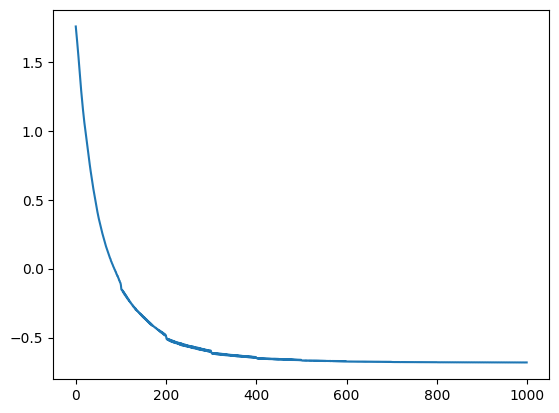

In [75]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [76]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-3.6827e-01, -1.0743e+00, -1.5213e+00, -1.8048e+00, -1.2799e+00,
         -1.0762e+00, -4.9946e-01, -2.3343e-01, -3.7907e-01,  5.3768e-01,
         -4.5109e-05, -4.7111e-01, -1.1276e+00,  1.8691e+00,  6.1680e-01,
          9.0769e-01, -4.5852e-05, -2.2390e-05, -5.9657e-05, -6.6831e-06,
          5.4694e-05, -1.0413e-05,  2.9749e-05, -4.2911e-05,  3.1342e-05,
          1.7040e-05,  1.6637e-05, -2.4961e-05,  1.7363e-05,  4.4132e-07,
          2.2240e-05,  2.0598e-05,  5.4148e-03, -9.1787e-05, -1.2238e-04,
          3.7072e-05, -1.1494e-04, -3.2713e-05, -1.1330e-05,  6.7670e-05,
          1.6580e-05,  1.1103e-04, -2.4156e-05,  2.9968e-05,  8.2539e-05,
          5.7903e-05, -5.2756e-06, -2.3031e-05,  7.7683e-05,  9.9820e-05,
          9.4961e-06,  1.2705e-04, -3.1812e-05,  2.0472e-05,  5.8412e-05,
          1.6738e-03, -3.4658e-05,  2.0131e-05, -2.3369e-05,  5.9662e-05,
          8.5089e-05,  2.7966e-05, -1.6308e-01,  7.0127e-05, -7.5452e-05,
          2.3652e-05,  2.5230e-05,  9.

tensor([[-3.6827e-01, -1.0743e+00, -1.5213e+00, -1.8048e+00, -1.2799e+00,
         -1.0762e+00, -4.9946e-01, -2.3343e-01, -3.7907e-01,  5.3768e-01,
         -4.5109e-05, -4.7111e-01, -1.1276e+00,  1.8691e+00,  6.1680e-01,
          9.0769e-01, -4.5852e-05, -2.2390e-05, -5.9657e-05, -6.6831e-06,
          5.4694e-05, -1.0413e-05,  2.9749e-05, -4.2911e-05,  3.1342e-05,
          1.7040e-05,  1.6637e-05, -2.4961e-05,  1.7363e-05,  4.4132e-07,
          2.2240e-05,  2.0598e-05,  5.4148e-03, -9.1787e-05, -1.2238e-04,
          3.7072e-05, -1.1494e-04, -3.2713e-05, -1.1330e-05,  6.7670e-05,
          1.6580e-05,  1.1103e-04, -2.4156e-05,  2.9968e-05,  8.2539e-05,
          5.7903e-05, -5.2756e-06, -2.3031e-05,  7.7683e-05,  9.9820e-05,
          9.4961e-06,  1.2705e-04, -3.1812e-05,  2.0472e-05,  5.8412e-05,
          1.6738e-03, -3.4658e-05,  2.0131e-05, -2.3369e-05,  5.9662e-05,
          8.5089e-05,  2.7966e-05, -1.6308e-01,  7.0127e-05, -7.5452e-05,
          2.3652e-05,  2.5230e-05,  9.

tensor([[-5.0042e-01, -1.2409e+00, -1.3321e+00, -1.7750e+00, -1.1324e+00,
         -9.9667e-01, -6.7170e-01, -4.0800e-01, -5.3473e-01,  7.3261e-01,
         -8.5524e-06, -6.8580e-01, -3.9928e-01,  1.7707e+00,  5.9721e-01,
          9.3995e-01,  2.1500e-07,  4.6488e-06,  1.4128e-05, -1.1658e-06,
          2.7550e-06, -1.0584e-06,  2.5644e-06,  6.3843e-05,  6.2253e-07,
         -2.9968e-06, -7.4250e-06, -3.6779e-06,  2.2397e-06,  3.1250e-06,
         -1.1200e-05,  2.1855e-06,  4.7296e-02, -2.9946e-07,  1.3171e-06,
         -1.2497e-05,  6.0660e-06, -1.2787e-05, -3.9223e-06, -2.6920e-06,
          2.7847e-06, -1.5846e-07,  1.0735e-06,  2.0631e-07,  7.7157e-06,
         -7.3803e-06, -5.0082e-06,  8.0588e-07,  5.0166e-07, -7.6305e-07,
          2.8682e-06, -7.5260e-06,  1.8648e-06,  4.6841e-06, -1.3874e-05,
          4.2181e-03, -2.8507e-06, -8.8528e-07, -1.3164e-05, -3.4730e-05,
          3.1266e-06, -1.6667e-06, -1.5954e-01, -1.7792e-06, -2.2344e-06,
          5.3875e-05,  9.6732e-06,  7.

In [77]:
################## Y_prior##################

y_prior_1= (model_1(train_x1)[0]).detach().squeeze()

y_prior_2= (model_2(train_x2)[0]).detach().squeeze()

y_prior_3= (model_3(train_x3)[0]).detach().squeeze()

BCE_loss_1 = loss_fn(y_prior_1,train_y1)
BCE_loss_2 = loss_fn(y_prior_2, train_y2)
BCE_loss_3 = loss_fn(y_prior_3, train_y3)
BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
BCE_loss
BCE_loss_1
BCE_loss_2
BCE_loss_3

tensor(0.1241)

tensor(0.0517)

tensor(0.0125)

tensor(0.0599)

In [78]:
y_p_1= (model_1(train_x1)[0]>0.5).clone().int()
t_p_1= train_y1.reshape(-1,1).int()

y_p_2= (model_2(train_x2)[0]>0.5).clone().int()
t_p_2= train_y2.reshape(-1,1).int()

y_p_3= (model_3(train_x3)[0]>0.5).clone().int()
t_p_3= train_y3.reshape(-1,1).int()

confusion_matrix(t_p_1,y_p_1)
confusion_matrix(t_p_2,y_p_2)
confusion_matrix(t_p_3,y_p_3)

array([[82,  0],
       [ 0, 78]])

array([[85,  0],
       [ 0, 75]])

array([[72,  0],
       [ 0, 88]])

In [79]:
################## third step##################
##为缩短运行时间，将lambda2固定##

#no prior
prior=0
# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3



# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)
    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)
    
    
    lambda1,lambda2,eta,lr= config["lambda1"], config["lambda2"],config["eta"],config["lr"]
    inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
    targets_1=(1-eta)*train_y1+eta*y_prior_1
    targets_2=(1-eta)*train_y2+eta*y_prior_2
    targets_3=(1-eta)*train_y3+eta*y_prior_3
    
    
    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
       
        
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()
        
        
        test_out_1, test_layer1_out_1, test_layer2_out_1,test_layer3_out_1= model_1(train_x1[idx_test])
        test_out_2, test_layer1_out_2, test_layer2_out_2,test_layer3_out_2= model_2(train_x2[idx_test])
        test_out_3, test_layer1_out_3, test_layer2_out_3,test_layer3_out_3= model_3(train_x3[idx_test])
        
# #         test_BCE_loss_1 = loss_fn(test_out_1, targets_1[idx_test].reshape(-1,1))
# #         test_BCE_loss_2 = loss_fn(test_out_2, targets_2[idx_test].reshape(-1,1))
# #         test_BCE_loss_3 = loss_fn(test_out_3, targets_3[idx_test].reshape(-1,1))

#         test_BCE_loss_1 = loss_fn(test_out_1, train_y1[idx_test].reshape(-1,1))
#         test_BCE_loss_2 = loss_fn(test_out_2, train_y2[idx_test].reshape(-1,1))
#         test_BCE_loss_3 = loss_fn(test_out_3, train_y3[idx_test].reshape(-1,1))
        
#         test_BCE_loss=test_BCE_loss_1+test_BCE_loss_2+test_BCE_loss_3
        
#         sum_test_BCE_loss+=test_BCE_loss.item()

#     #print("loss: ",)
#     tune.report(my_test_BCE_loss=sum_test_BCE_loss/split_num)

        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
#     inputs_1,targets_1 = train_x1,train_y1
#     inputs_2,targets_2 = train_x2,train_y2
#     inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
#     config={
#         "lambda1": tune.choice([0.01,0.02,0.03,0.04,0.05]),
#         "lambda2": tune.choice([0.001,0.002,0.003]),
#         "eta": tune.choice([0.06,0.09,0.1,0.12,0.15,0.17,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
#     }
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.002]),
         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),
         "lr":tune.choice([0.6,0.7,0.8])
                            }
#         "eta": tune.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])



    result = tune.run(
        train_model,  
        config=config,
        num_samples=160)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


Trial name,status,loc,eta,lambda1,lambda2,lr,iter,total time (s),my_test_sum_tGM
train_model_19582_00000,TERMINATED,10.224.0.12:30038,0.6,0.05,0.002,0.6,1,15.6082,0.903835
train_model_19582_00001,TERMINATED,10.224.0.12:30709,0.3,0.05,0.002,0.8,1,15.0181,0.913259
train_model_19582_00002,TERMINATED,10.224.0.12:30712,0.8,0.05,0.002,0.8,1,15.3292,0.93884
train_model_19582_00003,TERMINATED,10.224.0.12:30713,0.2,0.04,0.002,0.6,1,15.6536,0.870144
train_model_19582_00004,TERMINATED,10.224.0.12:30715,0.9,0.05,0.002,0.6,1,15.3682,0.923823
train_model_19582_00005,TERMINATED,10.224.0.12:30717,0.6,0.05,0.002,0.8,1,15.8659,0.934689
train_model_19582_00006,TERMINATED,10.224.0.12:30719,0.4,0.05,0.002,0.6,1,15.2023,0.901525
train_model_19582_00007,TERMINATED,10.224.0.12:30721,0.8,0.05,0.002,0.7,1,15.5533,0.937378
train_model_19582_00008,TERMINATED,10.224.0.12:30723,0.6,0.04,0.002,0.6,1,15.2225,0.886049
train_model_19582_00009,TERMINATED,10.224.0.12:30725,0.5,0.05,0.002,0.7,1,16.7432,0.919858


Result for train_model_19582_00000:
  date: 2022-11-13_19-41-41
  done: false
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9038350085092874
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 15.608227014541626
  time_this_iter_s: 15.608227014541626
  time_total_s: 15.608227014541626
  timestamp: 1668339701
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00000'
  warmup_time: 0.003755807876586914
  
Result for train_model_19582_00000:
  date: 2022-11-13_19-41-41
  done: true
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  experiment_tag: 0_eta=0.6000,lambda1=0.0500,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9038350085092874
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 15.608227014541626
  time_this_iter_s: 15.608227014541626
  time_total_s: 15.608227014541626
  timestamp: 1668339701
  time

Result for train_model_19582_00018:
  date: 2022-11-13_19-41-44
  done: true
  experiment_id: e51363b3e2b5465b95449f7362873ef6
  experiment_tag: 18_eta=0.4000,lambda1=0.0400,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8928210271636029
  node_ip: 10.224.0.12
  pid: 30743
  time_since_restore: 14.891647100448608
  time_this_iter_s: 14.891647100448608
  time_total_s: 14.891647100448608
  timestamp: 1668339704
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00018'
  warmup_time: 0.0063664913177490234
  
Result for train_model_19582_00004:
  date: 2022-11-13_19-41-45
  done: false
  experiment_id: 615a8fba64514db1bc75540757779b25
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9238229154288717
  node_ip: 10.224.0.12
  pid: 30715
  time_since_restore: 15.368163108825684
  time_this_iter_s: 15.368163108825684
  time_total_s: 15.368163108825684
  timestamp: 1668339705
  ti

Result for train_model_19582_00013:
  date: 2022-11-13_19-41-45
  done: false
  experiment_id: 32d0103f3b6a47759d73e8170b5d1d9d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8837511218000949
  node_ip: 10.224.0.12
  pid: 30733
  time_since_restore: 15.725363969802856
  time_this_iter_s: 15.725363969802856
  time_total_s: 15.725363969802856
  timestamp: 1668339705
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00013'
  warmup_time: 0.004391193389892578
  
Result for train_model_19582_00003:
  date: 2022-11-13_19-41-45
  done: false
  experiment_id: aca0234ce8384cf9a23777a4304fa3ad
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8701443631752553
  node_ip: 10.224.0.12
  pid: 30713
  time_since_restore: 15.653641939163208
  time_this_iter_s: 15.653641939163208
  time_total_s: 15.653641939163208
  timestamp: 1668339705
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_0000

Result for train_model_19582_00010:
  date: 2022-11-13_19-41-46
  done: true
  experiment_id: d58d05451c1042b1b257224d5be3d635
  experiment_tag: 10_eta=0.3000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8787062054681399
  node_ip: 10.224.0.12
  pid: 30727
  time_since_restore: 16.42131233215332
  time_this_iter_s: 16.42131233215332
  time_total_s: 16.42131233215332
  timestamp: 1668339706
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00010'
  warmup_time: 0.005919218063354492
  
Result for train_model_19582_00009:
  date: 2022-11-13_19-41-46
  done: false
  experiment_id: 6d5f2a00c8694576912351b506df35a3
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9198575922374144
  node_ip: 10.224.0.12
  pid: 30725
  time_since_restore: 16.743216276168823
  time_this_iter_s: 16.743216276168823
  time_total_s: 16.743216276168823
  timestamp: 1668339706
  timest

Result for train_model_19582_00044:
  date: 2022-11-13_19-41-59
  done: true
  experiment_id: 4504451f4bdb4c2ba40132314f89cfaf
  experiment_tag: 44_eta=0.7000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8912289920640397
  node_ip: 10.224.0.12
  pid: 30755
  time_since_restore: 13.948164463043213
  time_this_iter_s: 13.948164463043213
  time_total_s: 13.948164463043213
  timestamp: 1668339719
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00044'
  warmup_time: 0.004948616027832031
  
Result for train_model_19582_00036:
  date: 2022-11-13_19-41-59
  done: false
  experiment_id: c4fc08834d4e41a0b48a26d5bdf21209
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8776883319989418
  node_ip: 10.224.0.12
  pid: 30745
  time_since_restore: 14.289895296096802
  time_this_iter_s: 14.289895296096802
  time_total_s: 14.289895296096802
  timestamp: 1668339719
  tim

Result for train_model_19582_00052:
  date: 2022-11-13_19-41-59
  done: false
  experiment_id: aca0234ce8384cf9a23777a4304fa3ad
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8537814984781201
  node_ip: 10.224.0.12
  pid: 30713
  time_since_restore: 14.222955226898193
  time_this_iter_s: 14.222955226898193
  time_total_s: 14.222955226898193
  timestamp: 1668339719
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00052'
  warmup_time: 0.00892782211303711
  
Result for train_model_19582_00052:
  date: 2022-11-13_19-41-59
  done: true
  experiment_id: aca0234ce8384cf9a23777a4304fa3ad
  experiment_tag: 52_eta=0.5000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8537814984781201
  node_ip: 10.224.0.12
  pid: 30713
  time_since_restore: 14.222955226898193
  time_this_iter_s: 14.222955226898193
  time_total_s: 14.222955226898193
  timestamp: 1668339719
  time

Result for train_model_19582_00060:
  date: 2022-11-13_19-42-00
  done: false
  experiment_id: aaf4c6a92a754904a0c95546a1a37c11
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9132586620012058
  node_ip: 10.224.0.12
  pid: 30759
  time_since_restore: 14.497702598571777
  time_this_iter_s: 14.497702598571777
  time_total_s: 14.497702598571777
  timestamp: 1668339720
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00060'
  warmup_time: 0.0057179927825927734
  
Result for train_model_19582_00060:
  date: 2022-11-13_19-42-00
  done: true
  experiment_id: aaf4c6a92a754904a0c95546a1a37c11
  experiment_tag: 60_eta=0.3000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9132586620012058
  node_ip: 10.224.0.12
  pid: 30759
  time_since_restore: 14.497702598571777
  time_this_iter_s: 14.497702598571777
  time_total_s: 14.497702598571777
  timestamp: 1668339720
  ti

Result for train_model_19582_00071:
  date: 2022-11-13_19-42-12
  done: true
  experiment_id: 4504451f4bdb4c2ba40132314f89cfaf
  experiment_tag: 71_eta=0.9000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8514534142525617
  node_ip: 10.224.0.12
  pid: 30755
  time_since_restore: 13.73396611213684
  time_this_iter_s: 13.73396611213684
  time_total_s: 13.73396611213684
  timestamp: 1668339732
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00071'
  warmup_time: 0.004948616027832031
  
Result for train_model_19582_00064:
  date: 2022-11-13_19-42-12
  done: false
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.900615652169505
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 15.931142330169678
  time_this_iter_s: 15.931142330169678
  time_total_s: 15.931142330169678
  timestamp: 1668339732
  timeste

Result for train_model_19582_00073:
  date: 2022-11-13_19-42-13
  done: false
  experiment_id: 0ff1075ea77349f4ba1f68b2e6659866
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8764608699768978
  node_ip: 10.224.0.12
  pid: 30761
  time_since_restore: 14.198606729507446
  time_this_iter_s: 14.198606729507446
  time_total_s: 14.198606729507446
  timestamp: 1668339733
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00073'
  warmup_time: 0.004583120346069336
  
Result for train_model_19582_00073:
  date: 2022-11-13_19-42-13
  done: true
  experiment_id: 0ff1075ea77349f4ba1f68b2e6659866
  experiment_tag: 73_eta=0.1000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8764608699768978
  node_ip: 10.224.0.12
  pid: 30761
  time_since_restore: 14.198606729507446
  time_this_iter_s: 14.198606729507446
  time_total_s: 14.198606729507446
  timestamp: 1668339733
  tim

Result for train_model_19582_00082:
  date: 2022-11-13_19-42-14
  done: false
  experiment_id: cef25a9105dc44b2bacca2943a792b53
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8861615080399142
  node_ip: 10.224.0.12
  pid: 30751
  time_since_restore: 14.597009420394897
  time_this_iter_s: 14.597009420394897
  time_total_s: 14.597009420394897
  timestamp: 1668339734
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00082'
  warmup_time: 0.0067594051361083984
  
Result for train_model_19582_00087:
  date: 2022-11-13_19-42-14
  done: false
  experiment_id: ef954a94298541ce9b2e13aa180f2402
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9373781155581083
  node_ip: 10.224.0.12
  pid: 30729
  time_since_restore: 14.093273878097534
  time_this_iter_s: 14.093273878097534
  time_total_s: 14.093273878097534
  timestamp: 1668339734
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_000

Result for train_model_19582_00088:
  date: 2022-11-13_19-42-15
  done: false
  experiment_id: 1ecafa2c3e1648868733a3c4fe3ef57f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8514534142525617
  node_ip: 10.224.0.12
  pid: 30721
  time_since_restore: 15.165223598480225
  time_this_iter_s: 15.165223598480225
  time_total_s: 15.165223598480225
  timestamp: 1668339735
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00088'
  warmup_time: 0.00596165657043457
  
Result for train_model_19582_00088:
  date: 2022-11-13_19-42-15
  done: true
  experiment_id: 1ecafa2c3e1648868733a3c4fe3ef57f
  experiment_tag: 88_eta=0.9000,lambda1=0.0300,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8514534142525617
  node_ip: 10.224.0.12
  pid: 30721
  time_since_restore: 15.165223598480225
  time_this_iter_s: 15.165223598480225
  time_total_s: 15.165223598480225
  timestamp: 1668339735
  time

Result for train_model_19582_00096:
  date: 2022-11-13_19-42-26
  done: false
  experiment_id: 62246f3897ee43ce9be93ff0d5dfb4c0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9255304047645259
  node_ip: 10.224.0.12
  pid: 30723
  time_since_restore: 14.131386280059814
  time_this_iter_s: 14.131386280059814
  time_total_s: 14.131386280059814
  timestamp: 1668339746
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00096'
  warmup_time: 0.0042455196380615234
  
Result for train_model_19582_00096:
  date: 2022-11-13_19-42-26
  done: true
  experiment_id: 62246f3897ee43ce9be93ff0d5dfb4c0
  experiment_tag: 96_eta=0.8000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9255304047645259
  node_ip: 10.224.0.12
  pid: 30723
  time_since_restore: 14.131386280059814
  time_this_iter_s: 14.131386280059814
  time_total_s: 14.131386280059814
  timestamp: 1668339746
  ti

Result for train_model_19582_00107:
  date: 2022-11-13_19-42-28
  done: false
  experiment_id: 72d74af943354f129db023975758b734
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9255304047645259
  node_ip: 10.224.0.12
  pid: 30719
  time_since_restore: 14.375077724456787
  time_this_iter_s: 14.375077724456787
  time_total_s: 14.375077724456787
  timestamp: 1668339748
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00107'
  warmup_time: 0.006102085113525391
  
Result for train_model_19582_00107:
  date: 2022-11-13_19-42-28
  done: true
  experiment_id: 72d74af943354f129db023975758b734
  experiment_tag: 107_eta=0.8000,lambda1=0.0400,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9255304047645259
  node_ip: 10.224.0.12
  pid: 30719
  time_since_restore: 14.375077724456787
  time_this_iter_s: 14.375077724456787
  time_total_s: 14.375077724456787
  timestamp: 1668339748
  ti

Result for train_model_19582_00116:
  date: 2022-11-13_19-42-28
  done: false
  experiment_id: 12bf8fb0acc041ee9ab512d15b2f7cad
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9110363974384406
  node_ip: 10.224.0.12
  pid: 30770
  time_since_restore: 14.329932451248169
  time_this_iter_s: 14.329932451248169
  time_total_s: 14.329932451248169
  timestamp: 1668339748
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00116'
  warmup_time: 0.006588935852050781
  
Result for train_model_19582_00116:
  date: 2022-11-13_19-42-28
  done: true
  experiment_id: 12bf8fb0acc041ee9ab512d15b2f7cad
  experiment_tag: 116_eta=0.2000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9110363974384406
  node_ip: 10.224.0.12
  pid: 30770
  time_since_restore: 14.329932451248169
  time_this_iter_s: 14.329932451248169
  time_total_s: 14.329932451248169
  timestamp: 1668339748
  ti

Result for train_model_19582_00123:
  date: 2022-11-13_19-42-30
  done: false
  experiment_id: a38dd6a495794c50bd103159dc5b4ec2
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9330645129634048
  node_ip: 10.224.0.12
  pid: 30768
  time_since_restore: 14.76933741569519
  time_this_iter_s: 14.76933741569519
  time_total_s: 14.76933741569519
  timestamp: 1668339750
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00123'
  warmup_time: 0.005151510238647461
  
Result for train_model_19582_00123:
  date: 2022-11-13_19-42-30
  done: true
  experiment_id: a38dd6a495794c50bd103159dc5b4ec2
  experiment_tag: 123_eta=0.7000,lambda1=0.0500,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9330645129634048
  node_ip: 10.224.0.12
  pid: 30768
  time_since_restore: 14.76933741569519
  time_this_iter_s: 14.76933741569519
  time_total_s: 14.76933741569519
  timestamp: 1668339750
  timestep

Result for train_model_19582_00130:
  date: 2022-11-13_19-42-40
  done: false
  experiment_id: 62246f3897ee43ce9be93ff0d5dfb4c0
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8660274944141146
  node_ip: 10.224.0.12
  pid: 30723
  time_since_restore: 13.976139783859253
  time_this_iter_s: 13.976139783859253
  time_total_s: 13.976139783859253
  timestamp: 1668339760
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00130'
  warmup_time: 0.0042455196380615234
  
Result for train_model_19582_00130:
  date: 2022-11-13_19-42-40
  done: true
  experiment_id: 62246f3897ee43ce9be93ff0d5dfb4c0
  experiment_tag: 130_eta=0.1000,lambda1=0.0300,lambda2=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8660274944141146
  node_ip: 10.224.0.12
  pid: 30723
  time_since_restore: 13.976139783859253
  time_this_iter_s: 13.976139783859253
  time_total_s: 13.976139783859253
  timestamp: 1668339760
  t

Result for train_model_19582_00137:
  date: 2022-11-13_19-42-42
  done: false
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8822124211536979
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 14.732045412063599
  time_this_iter_s: 14.732045412063599
  time_total_s: 14.732045412063599
  timestamp: 1668339762
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00137'
  warmup_time: 0.003755807876586914
  
Result for train_model_19582_00137:
  date: 2022-11-13_19-42-42
  done: true
  experiment_id: e58a49838b2446bd83f7e27782f83f74
  experiment_tag: 137_eta=0.6000,lambda1=0.0300,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8822124211536979
  node_ip: 10.224.0.12
  pid: 30038
  time_since_restore: 14.732045412063599
  time_this_iter_s: 14.732045412063599
  time_total_s: 14.732045412063599
  timestamp: 1668339762
  ti

Result for train_model_19582_00151:
  date: 2022-11-13_19-42-43
  done: false
  experiment_id: dee32cc82fd044a1a5f94122a97e2b96
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.911984526647968
  node_ip: 10.224.0.12
  pid: 30739
  time_since_restore: 13.678586721420288
  time_this_iter_s: 13.678586721420288
  time_total_s: 13.678586721420288
  timestamp: 1668339763
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00151'
  warmup_time: 0.005663156509399414
  
Result for train_model_19582_00151:
  date: 2022-11-13_19-42-43
  done: true
  experiment_id: dee32cc82fd044a1a5f94122a97e2b96
  experiment_tag: 151_eta=0.7000,lambda1=0.0500,lambda2=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.911984526647968
  node_ip: 10.224.0.12
  pid: 30739
  time_since_restore: 13.678586721420288
  time_this_iter_s: 13.678586721420288
  time_total_s: 13.678586721420288
  timestamp: 1668339763
  time

Result for train_model_19582_00158:
  date: 2022-11-13_19-42-44
  done: false
  experiment_id: 1ecafa2c3e1648868733a3c4fe3ef57f
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9408935955242154
  node_ip: 10.224.0.12
  pid: 30721
  time_since_restore: 13.208621263504028
  time_this_iter_s: 13.208621263504028
  time_total_s: 13.208621263504028
  timestamp: 1668339764
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '19582_00158'
  warmup_time: 0.00596165657043457
  
Result for train_model_19582_00158:
  date: 2022-11-13_19-42-44
  done: true
  experiment_id: 1ecafa2c3e1648868733a3c4fe3ef57f
  experiment_tag: 158_eta=0.7000,lambda1=0.0500,lambda2=0.0020,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9408935955242154
  node_ip: 10.224.0.12
  pid: 30721
  time_since_restore: 13.208621263504028
  time_this_iter_s: 13.208621263504028
  time_total_s: 13.208621263504028
  timestamp: 1668339764
  tim

2022-11-13 19:42:46,709	INFO tune.py:758 -- Total run time: 83.50 seconds (83.27 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
19582_00000         0.903835         15.608227  True            None   
19582_00001         0.913259         15.018144  True            None   
19582_00002         0.938840         15.329222  True            None   
19582_00003         0.870144         15.653642  True            None   
19582_00004         0.923823         15.368163  True            None   
...                      ...               ...   ...             ...   
19582_00155         0.867670         13.389029  True            None   
19582_00156         0.911089         13.087188  True            None   
19582_00157         0.853781         13.331625  True            None   
19582_00158         0.940894         13.208621  True            None   
19582_00159         0.923823         11.805140  True            None   

     

In [80]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final GM: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final GM: 0.9410284405516173


{'lambda1': 0.05, 'lambda2': 0.002, 'eta': 0.9, 'lr': 0.8}

In [81]:
################## second step##################

#no prior
prior=0

# set hyperparamters
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,eta,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["eta"],final_parameter["lr"]
learning_rate=lr
max_iteration=1000


inputs_1,inputs_2,inputs_3=train_x1,train_x2,train_x3
targets_1=(1-eta)*train_y1+eta*y_prior_1
targets_2=(1-eta)*train_y2+eta*y_prior_2
targets_3=(1-eta)*train_y3+eta*y_prior_3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=2)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))
    
    l2_regularization = lambda2 * torch.sum(all_linear234_params.pow(2))
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.4325, grad_fn=<AddBackward0>)

tensor(0.1431, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.0155, grad_fn=<BinaryCrossEntropyBackward0>)

tensor(0.1437, grad_fn=<BinaryCrossEntropyBackward0>)

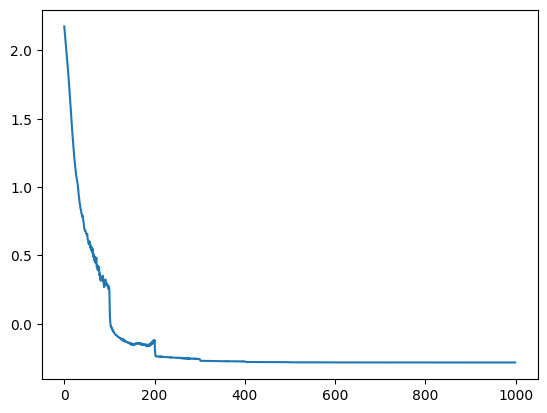

In [82]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

loss_fn(out_1, train_y1.reshape(-1,1))
loss_fn(out_2, train_y2.reshape(-1,1))
loss_fn(out_3, train_y3.reshape(-1,1))

In [83]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-1.2729e-01, -1.2070e-01, -1.8623e-01, -1.1179e-01, -1.7567e-01,
          1.3397e-01, -1.7035e-01, -9.6188e-02,  1.4363e-01,  2.0452e-01,
         -1.8745e-06, -4.8124e-08,  2.1316e-06, -2.8661e-03,  3.1761e-06,
          1.1932e-06, -1.1070e-06,  2.1226e-07, -2.0428e-06, -1.7662e-06,
          1.3885e-06, -4.8231e-07, -3.5084e-06, -6.3221e-05,  2.6613e-06,
         -2.7282e-07,  5.7752e-07, -2.7110e-06, -3.1199e-06, -1.0121e-06,
          3.6760e-06,  1.9187e-07,  1.4116e-02,  2.2539e-06, -2.1629e-06,
         -1.8518e-06,  2.0971e-06,  2.5885e-06, -1.4399e-06,  1.7137e-06,
          1.8175e-06, -2.8717e-07,  4.5464e-09,  3.1647e-06, -3.4453e-06,
         -9.2393e-07, -1.9261e-06, -1.3048e-07, -1.2538e-06,  2.7852e-06,
          8.4658e-07, -3.6924e-06, -2.1638e-06, -8.3108e-07,  1.7998e-06,
         -2.2454e-07,  2.8836e-06,  2.8277e-06, -4.2300e-07, -1.6687e-06,
         -7.6285e-07, -9.4721e-07, -1.5197e-02,  1.3575e-06, -8.4698e-07,
          2.4219e-06,  3.3457e-06,  3.

tensor([[-1.2729e-01, -1.2070e-01, -1.8623e-01, -1.1179e-01, -1.7567e-01,
          1.3397e-01, -1.7035e-01, -9.6188e-02,  1.4363e-01,  2.0452e-01,
         -1.8745e-06, -4.8124e-08,  2.1316e-06, -2.8661e-03,  3.1761e-06,
          1.1932e-06, -1.1070e-06,  2.1226e-07, -2.0428e-06, -1.7662e-06,
          1.3885e-06, -4.8231e-07, -3.5084e-06, -6.3221e-05,  2.6613e-06,
         -2.7282e-07,  5.7752e-07, -2.7110e-06, -3.1199e-06, -1.0121e-06,
          3.6760e-06,  1.9187e-07,  1.4116e-02,  2.2539e-06, -2.1629e-06,
         -1.8518e-06,  2.0971e-06,  2.5885e-06, -1.4399e-06,  1.7137e-06,
          1.8175e-06, -2.8717e-07,  4.5464e-09,  3.1647e-06, -3.4453e-06,
         -9.2393e-07, -1.9261e-06, -1.3048e-07, -1.2538e-06,  2.7852e-06,
          8.4658e-07, -3.6924e-06, -2.1638e-06, -8.3108e-07,  1.7998e-06,
         -2.2454e-07,  2.8836e-06,  2.8277e-06, -4.2300e-07, -1.6687e-06,
         -7.6285e-07, -9.4721e-07, -1.5197e-02,  1.3575e-06, -8.4698e-07,
          2.4219e-06,  3.3457e-06,  3.

tensor([[-1.5949e-01, -1.5985e-01, -2.1366e-01, -1.4209e-01,  2.0299e-01,
         -1.5159e-01, -2.3908e-01, -1.3098e-01, -2.0774e-01, -2.5107e-01,
         -5.1428e-07, -1.7675e-08,  2.2025e-07,  2.3199e-02, -7.8276e-09,
         -8.6585e-08,  7.4174e-09,  2.5426e-07,  2.2036e-07, -1.1373e-07,
          3.0776e-08, -2.1777e-08,  2.8894e-08,  3.3411e-03, -9.5327e-07,
         -6.1641e-09, -6.2706e-07,  6.1332e-08, -7.2128e-07, -1.2985e-07,
         -7.6627e-08, -2.2828e-09,  1.8206e-02,  9.6265e-07, -9.1774e-09,
         -4.9530e-07,  1.2470e-07, -1.2491e-08, -3.5349e-07,  1.1643e-06,
          2.5740e-07,  1.4291e-08, -2.3457e-06,  4.8340e-09, -6.0685e-08,
          1.7710e-07, -5.3653e-08,  1.7868e-08, -6.1220e-07,  6.3676e-07,
         -2.0460e-08, -2.2033e-07,  2.8037e-08,  9.7984e-07,  3.6418e-07,
         -6.9050e-07, -2.3602e-08,  1.7321e-07, -3.3588e-08, -1.1508e-07,
          4.3530e-07, -5.9793e-08, -1.5695e-02, -8.2820e-08, -1.5277e-07,
         -2.7201e-07, -2.2251e-07,  5.

In [84]:

model_1(test_x1)[0].squeeze()
test_y1.squeeze()
model_2(test_x2)[0].squeeze()
test_y2.squeeze()
model_3(test_x3)[0].squeeze()
test_y3.squeeze()


tensor([9.8629e-01, 1.6649e-01, 2.2053e-02, 9.8247e-01, 9.4854e-01, 9.9003e-01,
        9.6850e-01, 8.9416e-05, 9.3342e-01, 9.8977e-01, 1.2230e-02, 8.9069e-01,
        7.5648e-01, 6.0270e-01, 2.0401e-02, 3.8413e-02, 7.7234e-01, 9.1466e-02,
        9.8744e-01, 9.2146e-01, 1.9258e-01, 9.8354e-01, 8.1597e-01, 9.8514e-01,
        1.3964e-01, 9.7900e-01, 1.1062e-01, 2.2658e-01, 8.9243e-01, 1.4245e-02,
        6.1158e-01, 4.3107e-04, 5.9352e-04, 6.1594e-03, 1.9662e-01, 1.8347e-01,
        4.2697e-01, 9.7678e-01, 1.9961e-02, 4.6458e-01],
       grad_fn=<SqueezeBackward0>)

tensor([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
        1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.])

tensor([0.0114, 0.9790, 0.1355, 0.2498, 0.4274, 0.1636, 0.0619, 0.9448, 0.0067,
        0.0049, 0.3218, 0.2291, 0.0038, 0.9991, 0.9958, 0.8763, 0.0738, 0.0813,
        0.0111, 0.9962, 0.9585, 0.9469, 0.0052, 0.9949, 0.0153, 0.0033, 0.5578,
        0.1334, 0.0133, 0.9656, 0.5137, 0.1663, 0.9996, 0.0793, 0.0071, 0.9868,
        0.2085, 0.7230, 0.9966, 0.9934], grad_fn=<SqueezeBackward0>)

tensor([0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 1., 1.])

tensor([9.7635e-01, 9.8503e-01, 2.7939e-01, 9.7825e-01, 1.1860e-01, 9.2438e-01,
        1.9617e-01, 4.3819e-01, 9.8625e-01, 7.4546e-02, 8.9738e-01, 1.0644e-04,
        9.9145e-01, 3.5298e-04, 9.7296e-01, 1.1837e-03, 9.8572e-01, 9.9367e-01,
        6.5174e-01, 9.3205e-01, 9.8697e-01, 1.6859e-02, 9.0750e-01, 3.5625e-03,
        1.9075e-02, 1.5107e-01, 9.9228e-01, 9.9540e-01, 9.8395e-01, 4.1688e-01,
        8.3027e-01, 1.2363e-01, 9.5675e-02, 3.2152e-01, 4.7448e-02, 4.9648e-03,
        1.2046e-02, 5.3272e-01, 1.2116e-02, 7.8584e-01],
       grad_fn=<SqueezeBackward0>)

tensor([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.])

In [85]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[58,  5],
       [ 5, 52]])

0.9122807017543859

0.9206349206349206

0.9166666666666666

0.9122807017543859

0.9122807017543859

In [86]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[20,  2],
       [ 0, 18]])

1.0

0.9090909090909091

array([[18,  2],
       [ 5, 15]])

0.75

0.9

array([[20,  1],
       [ 0, 19]])

1.0

0.9523809523809523

In [87]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight

array([[-1.2729214e-01, -1.2069799e-01, -1.8623360e-01, -1.1179250e-01,
        -1.7567100e-01,  1.3397416e-01, -1.7035024e-01, -9.6187815e-02,
         1.4363399e-01,  2.0452313e-01, -1.8745031e-06, -4.8123944e-08,
         2.1315864e-06, -2.8660903e-03,  3.1761347e-06,  1.1931995e-06,
        -1.1069817e-06,  2.1225621e-07, -2.0427522e-06, -1.7662397e-06,
         1.3884879e-06, -4.8230805e-07, -3.5084222e-06, -6.3220883e-05,
         2.6612884e-06, -2.7281740e-07,  5.7752453e-07, -2.7109975e-06,
        -3.1199042e-06, -1.0121394e-06,  3.6760464e-06,  1.9186642e-07,
         1.4116176e-02,  2.2539100e-06, -2.1628769e-06, -1.8517701e-06,
         2.0971293e-06,  2.5884574e-06, -1.4398507e-06,  1.7137371e-06,
         1.8175356e-06, -2.8717062e-07,  4.5464312e-09,  3.1646500e-06,
        -3.4452751e-06, -9.2393054e-07, -1.9260990e-06, -1.3048047e-07,
        -1.2538006e-06,  2.7851688e-06,  8.4657836e-07, -3.6923536e-06,
        -2.1637713e-06, -8.3108029e-07,  1.7998231e-06, -2.24542

array([[-1.2729214e-01, -1.2069799e-01, -1.8623360e-01, -1.1179250e-01,
        -1.7567100e-01,  1.3397416e-01, -1.7035024e-01, -9.6187815e-02,
         1.4363399e-01,  2.0452313e-01, -1.8745031e-06, -4.8123944e-08,
         2.1315864e-06, -2.8660903e-03,  3.1761347e-06,  1.1931995e-06,
        -1.1069817e-06,  2.1225621e-07, -2.0427522e-06, -1.7662397e-06,
         1.3884879e-06, -4.8230805e-07, -3.5084222e-06, -6.3220883e-05,
         2.6612884e-06, -2.7281740e-07,  5.7752453e-07, -2.7109975e-06,
        -3.1199042e-06, -1.0121394e-06,  3.6760464e-06,  1.9186642e-07,
         1.4116176e-02,  2.2539100e-06, -2.1628769e-06, -1.8517701e-06,
         2.0971293e-06,  2.5884574e-06, -1.4398507e-06,  1.7137371e-06,
         1.8175356e-06, -2.8717062e-07,  4.5464312e-09,  3.1646500e-06,
        -3.4452751e-06, -9.2393054e-07, -1.9260990e-06, -1.3048047e-07,
        -1.2538006e-06,  2.7851688e-06,  8.4657836e-07, -3.6923536e-06,
        -2.1637713e-06, -8.3108029e-07,  1.7998231e-06, -2.24542

array([[-1.59486875e-01, -1.59852237e-01, -2.13664025e-01,
        -1.42089859e-01,  2.02985883e-01, -1.51586041e-01,
        -2.39080057e-01, -1.30980670e-01, -2.07740128e-01,
        -2.51066923e-01, -5.14277360e-07, -1.76746546e-08,
         2.20248367e-07,  2.31987648e-02, -7.82756615e-09,
        -8.65850893e-08,  7.41739115e-09,  2.54256634e-07,
         2.20359638e-07, -1.13725847e-07,  3.07763948e-08,
        -2.17772218e-08,  2.88941280e-08,  3.34111182e-03,
        -9.53268795e-07, -6.16411722e-09, -6.27055726e-07,
         6.13324858e-08, -7.21284835e-07, -1.29850292e-07,
        -7.66269466e-08, -2.28276820e-09,  1.82059165e-02,
         9.62645686e-07, -9.17736553e-09, -4.95304050e-07,
         1.24700080e-07, -1.24912338e-08, -3.53488218e-07,
         1.16430999e-06,  2.57399023e-07,  1.42905359e-08,
        -2.34571917e-06,  4.83402030e-09, -6.06846342e-08,
         1.77102649e-07, -5.36528617e-08,  1.78681763e-08,
        -6.12202143e-07,  6.36762195e-07, -2.04595931e-0

In [88]:
threshold=0.12
mcl_w=np.zeros(p)

for i in range(p):
    mcl_w[i]=cubic_root(model_1_weight[0,i]*model_2_weight[0,i]*model_3_weight[0,i])

max_mcl_w=max(abs(mcl_w))
for i in range(p):
    if (abs(mcl_w[i]))<=threshold*max_mcl_w:
        model_1_weight[0,i]=0
        model_2_weight[0,i]=0
        model_3_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        model_2_weight[0,i]=model_2_weight[0,i]
        model_3_weight[0,i]=model_3_weight[0,i]
index=np.nonzero(model_1_weight)[1]
model_1_weight
final_index=index+1
final_index
len(index)

array([[-0.12729214, -0.12069799, -0.1862336 , -0.1117925 , -0.175671  ,
         0.13397416, -0.17035024, -0.09618782,  0.14363399,  0.20452313,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

10

In [89]:
index=np.nonzero(model_1_weight)[1]
index=index.tolist()
index=set(index)

beta=np.array(beta_1)
trueindex=np.where(beta!=0)[0]
trueindex=trueindex.tolist()
trueindex=set(trueindex)

TP=len(trueindex.intersection(index))
FP=len(index.difference(trueindex))
FN=len(trueindex)-TP
TN=p-len(trueindex)-FP
vsSEN=TP/(TP+FN)#vsSEN.
vsSPE=TN/(TN+FP)#vsSPE
vsSEN
vsSPE
math.sqrt(vsSEN*vsSPE)#vsGM
vsMR=(FP+FN)/(TP+FN+TN+FP)#vsMR
1-vsMR#vsCCR

1.0

1.0

1.0

1.0

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}